# Manipulate 2011 LSOA boundary data from EW to London

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Produce a `.csv` containing geometries that can later be joined to other data for analysis. This file will be used by students regularly so should be a relatively small file on disk.

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-08-15


In [2]:
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Generalised Boundaries

See below for previous manipulation of the full resolution LSOA boundaries. In 2023, files with boundaries generalised to 20m resolution were released, providing much smaller files appropriate for student use. Tyhe code in this first section manipulated these generalised boundaries.


were released containing the digital vector boundaries for Lower layer Super Output Areas in England and Wales, as at 21 March 2021, generalised (20m) and clipped to the coastline (Mean High Water mark).

[Generalised (20m) LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lsoa-dec-2011-boundaries-generalised-clipped-bgc-ew-v3-2/about) (clipped to the coastline) data downloaded [2023-08-15] as *LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3_2838119129839044524.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)
Contains both Ordnance Survey and ONS Intellectual Property Rights.

In [3]:
census_ipath = Path("../data/inputs/geographies/census/")
boundaries = gpd.read_file(census_ipath / "LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3_2838119129839044524/LSOA_2011_EW_BGC_V3.shp").set_index('LSOA11NM')

In [4]:
boundaries.head()

,LSOA11CD,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
LSOA11NM,,,,,,,,
City of London 001A,E01000001,City of London 001A,532129,181625,-0.097060,51.5181,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.230, 532162.491 18..."
City of London 001B,E01000002,City of London 001B,532480,181699,-0.091970,51.5187,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
City of London 001C,E01000003,City of London 001C,532245,182036,-0.095230,51.5218,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.250 18..."
City of London 001E,E01000005,City of London 001E,533581,181265,-0.076280,51.5145,4ddaf5e4-e47f-4312-89a0-923ffec028a6,"POLYGON ((533808.018 180767.774, 533649.037 18..."
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,544994,184276,0.089318,51.5388,1c04702a-b662-4cfc-aab9-2c3e0f2d5e29,"POLYGON ((545122.049 184314.931, 545271.849 18..."


### Subset to London only
Looks like London LSOAs are listed at the top, so slice down to bottom LSOA (Westminster 013D)

In [5]:
london = boundaries.loc[:'Westminster 013D',:]
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4642 entries, City of London 001A to Westminster 013D
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4642 non-null   object  
 1   LSOA11NMW  4642 non-null   object  
 2   BNG_E      4642 non-null   int64   
 3   BNG_N      4642 non-null   int64   
 4   LONG       4642 non-null   float64 
 5   LAT        4642 non-null   float64 
 6   GlobalID   4642 non-null   object  
 7   geometry   4642 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 326.4+ KB


<AxesSubplot:>

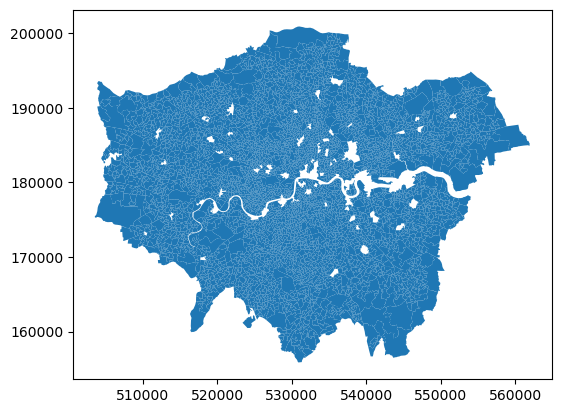

In [6]:
london.plot()

Unfortunately, we have missing polygons - so maybe the LSOAs are not sorted well and there are London LSOAs further down the DataFrame. So, we should select LSOAs based on borough names (plus City). 

Get a lookup table for unique Borough (LAD) names and to join MSOA and LAD info to LSOA geometries. 

[Original data](https://geoportal.statistics.gov.uk/datasets/ons::output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales/about) downloaded [2022-08-24] from ONS and saved as *OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv*. 

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [7]:
census_ipath = Path("../data/inputs/geographies/census/")
lookup_filepath = census_ipath/"OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv"

lookup = pd.read_csv(lookup_filepath)
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   LAD11NMW  10036 non-null   object
 8   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 12.5+ MB


/tmp/ipykernel_52539/3535988000.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv(lookup_filepath)


In [8]:
lookup.drop('LAD11NMW', axis=1, inplace=True)   #drop welsh names (not needed for London)
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 11.1+ MB


In [9]:
lads = pd.unique(lookup.LAD11NM)
lads

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Bolton', 'Bury',
       'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport',
       'Tameside', 'Trafford', 'Wigan', 'Knowsley', 'Liverpool',
       'St. Helens', 'Sefton', 'Wirral', 'Barnsley', 'Doncaster',
       'Rotherham', 'Sheffield', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Birmingham',
       'Coventry', 'Dudley', 'Sandwell', 'Solihull', 'Walsall',
       'Wolverhampton', 'Bradford', 'Calderdale', 'Kirklees'

In [10]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [11]:
len(london_lads)

33

We want to use the LSOA names as a Series below, so extract them from index (and set `dtype` to string)

In [12]:
boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34753 entries, City of London 001A to Swansea 025H
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   34753 non-null  object  
 1   LSOA11NMW  34753 non-null  object  
 2   BNG_E      34753 non-null  int64   
 3   BNG_N      34753 non-null  int64   
 4   LONG       34753 non-null  float64 
 5   LAT        34753 non-null  float64 
 6   GlobalID   34753 non-null  object  
 7   geometry   34753 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 3.4+ MB


In [13]:
boundaries = boundaries.reset_index()
boundaries['LSOA11NM'] = boundaries['LSOA11NM'].astype('string')

Now filter to retain only rows for _LSOA21NM_ that contain some text in the _london_lads_ list (do shallow copy to avoid index issue later)

In [14]:
london = boundaries[boundaries['LSOA11NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4881 entries, 0 to 32821
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11NM   4881 non-null   string  
 1   LSOA11CD   4881 non-null   object  
 2   LSOA11NMW  4881 non-null   object  
 3   BNG_E      4881 non-null   int64   
 4   BNG_N      4881 non-null   int64   
 5   LONG       4881 non-null   float64 
 6   LAT        4881 non-null   float64 
 7   GlobalID   4881 non-null   object  
 8   geometry   4881 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(3), string(1)
memory usage: 381.3+ KB


Plot to check

<AxesSubplot:>

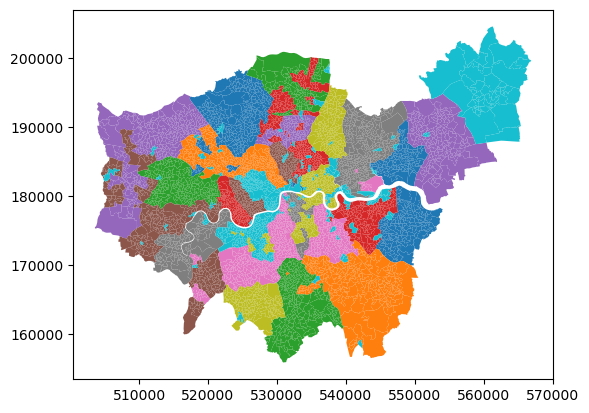

In [15]:
london.plot('LSOA11CD')

What's going on here? We have some unexpected LSOAs in north east. Let's plot each 'borough' in turn to investigate:

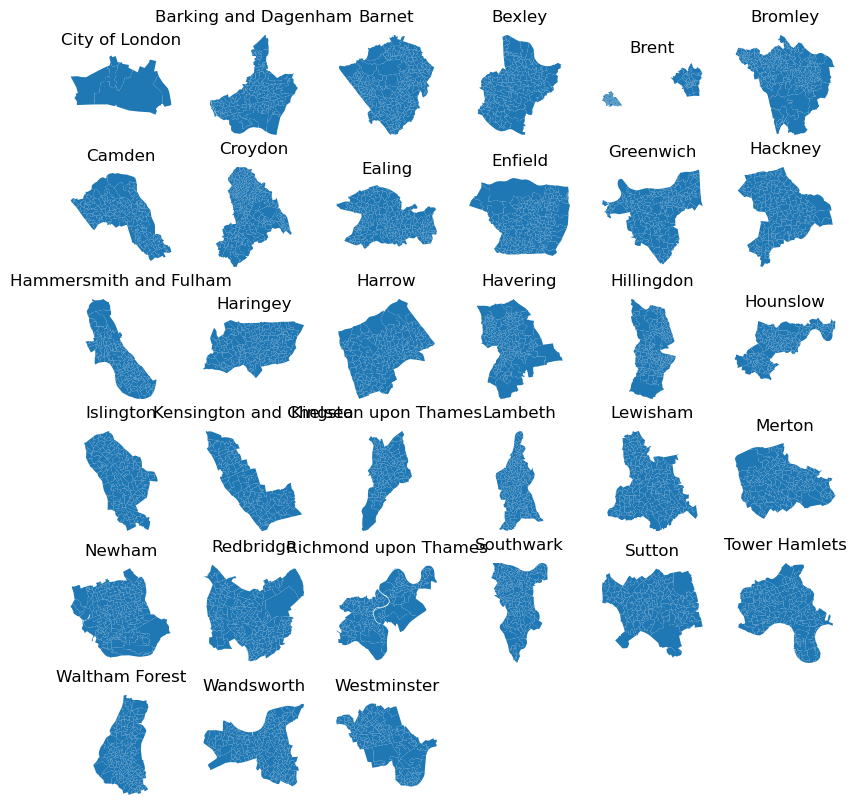

In [16]:
fig, axs = plt.subplots(6,6,figsize=(10,10))
row = 0
col = 0

for i, x in enumerate(london_lads):
    l = london[london['LSOA11NM'].str.contains(x)]
    
    col = i%6
    theax=axs[row][col]

    ax = l.plot(ax=theax)
    theax.set_title(x)
    theax.axis('off')
    
    if col == 5: 
        row += 1

for ax in axs.flat[len(london_lads):]:
    ax.remove()
    
plt.show()

It looks like Brent is the problem, as it has been split into two! 

<AxesSubplot:>

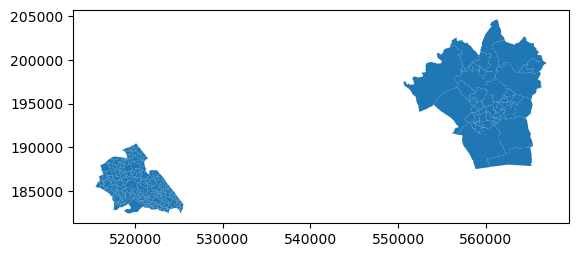

In [17]:
london[london['LSOA11NM'].str.contains('Brent')].plot()

In [18]:
london[london['LSOA11NM'].str.contains('Brent')]

,LSOA11NM,LSOA11CD,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
465,Brent 026A,E01000471,Brent 026A,518589,183431,-0.29150,51.5373,e4757c87-3661-4a9a-8d98-5307f45c5ca1,"POLYGON ((518728.138 183645.948, 518850.546 18..."
466,Brent 029A,E01000472,Brent 029A,518000,183287,-0.30004,51.5362,a096b0e8-6329-44b2-bc72-95fe4c619a2c,"POLYGON ((518124.000 183710.000, 518069.892 18..."
467,Brent 029B,E01000473,Brent 029B,518317,184163,-0.29517,51.5440,5b705888-d863-44c5-8f6e-bfd7c578ef4c,"POLYGON ((518402.056 184434.910, 518283.248 18..."
468,Brent 026B,E01000474,Brent 026B,518639,184404,-0.29045,51.5461,188492c9-6d55-45f8-963d-430ed13dbada,"POLYGON ((518928.910 184521.207, 518913.814 18..."
469,Brent 029C,E01000475,Brent 029C,517571,184056,-0.30596,51.5432,e30d658f-96b9-45c1-a153-e55832fc98d5,"POLYGON ((518034.791 183756.793, 517959.000 18..."
...,...,...,...,...,...,...,...,...,...
32549,Brent 027F,E01033456,Brent 027F,520539,184057,-0.26318,51.5425,0b7656b9-68fe-4937-8097-f3ba677ed8cf,"POLYGON ((520500.479 184284.760, 520551.414 18..."
32550,Brent 017G,E01033457,Brent 017G,518853,185975,-0.28684,51.5601,24e108dc-eb3a-4cc2-9ab6-6354c5daca91,"POLYGON ((519108.471 186052.681, 518985.497 18..."
32556,Brent 003G,E01033463,Brent 003G,518159,188532,-0.29598,51.5833,911faed0-4f64-46f6-950a-b7a7ef32a903,"POLYGON ((518722.126 188825.120, 518869.094 18..."
32557,Brent 010F,E01033464,Brent 010F,521746,186514,-0.24494,51.5644,c8d70928-b1fa-407a-ad9b-d0d56d012d9e,"POLYGON ((521772.706 186717.882, 521793.000 18..."


Last few rows show that Brentwood is being included as well as Brent!  So filter Brentwood out

In [19]:
london_noBrentwood = london[~london['LSOA11NM'].str.contains('Brentwood')]

In [20]:
london_noBrentwood.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 32821
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11NM   4835 non-null   string  
 1   LSOA11CD   4835 non-null   object  
 2   LSOA11NMW  4835 non-null   object  
 3   BNG_E      4835 non-null   int64   
 4   BNG_N      4835 non-null   int64   
 5   LONG       4835 non-null   float64 
 6   LAT        4835 non-null   float64 
 7   GlobalID   4835 non-null   object  
 8   geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(3), string(1)
memory usage: 377.7+ KB


<AxesSubplot:>

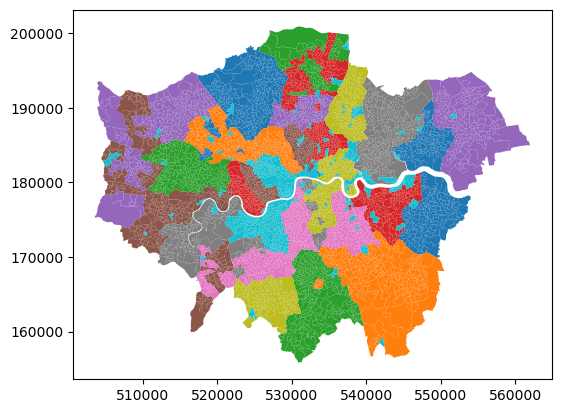

In [21]:
london_noBrentwood.plot('LSOA11CD')

This looks like the extent of greater London. 

### Join MSOA and LAD info

In [22]:
lookup.drop(['OA11CD', 'ObjectId'], axis=1, inplace=True)
lookup.drop_duplicates(subset=['LSOA11NM'], inplace=True)
lookup.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London
8,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London
16,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London
17,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London


In [23]:
merge_london = pd.merge(london_noBrentwood, lookup, how='left', on='LSOA11CD')

In [24]:
merge_london = merge_london[['LSOA11CD', 'LSOA11NM_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'geometry']]
merge_london.rename(columns = {'LSOA11NM_x':'LSOA11NM'}, inplace = True)
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   string  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(5), string(1)
memory usage: 302.2+ KB


Write to file

In [25]:
census_opath = Path("../data/geographies/census/")
merge_london.to_file(census_opath / "london-2011-lsoa-gen20.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [26]:
merge_london.to_csv(census_opath / "london-2011-lsoa-gen20.csv", index=False)  

csv written is ~6MB

### Final checks

Read back in to check:

In [27]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = census_opath / "london-2011-lsoa-gen20.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [28]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


<AxesSubplot:>

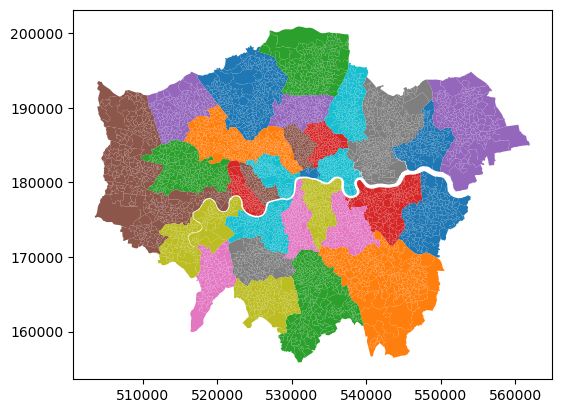

In [29]:
gdf.plot(column='LAD11CD')

<AxesSubplot:>

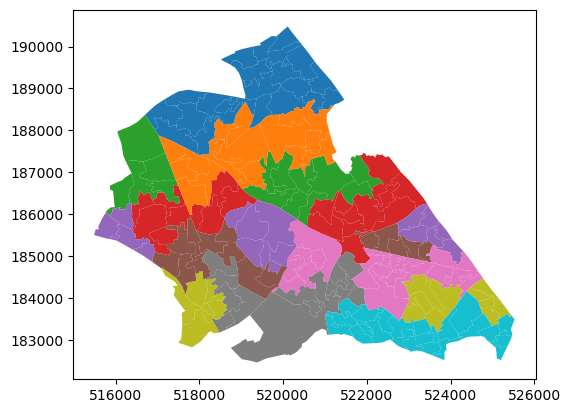

In [30]:
gdf[gdf['LSOA11NM'].str.contains('Brent')].plot(column='MSOA11NM')

## Full Resolution

[LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2011-boundaries-full-clipped-bfc-ew-v3/about) data downloaded [2022-08-24] as *Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [31]:
boundaries = gpd.read_file(census_ipath / "Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3/Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3.shp")

### Subset to London only 

Get a lookup table for unique Borough (LAD) names and to join MSOA and LAD info to LSOA geometries. 

[Original data](https://geoportal.statistics.gov.uk/datasets/ons::output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales/about) downloaded [2022-08-24] from ONS and saved as *OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv*. 

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [32]:
census_ipath = Path("../data/inputs/geographies/census/")
lookup_filepath = census_ipath/"OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv"

lookup = pd.read_csv(lookup_filepath)
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   LAD11NMW  10036 non-null   object
 8   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 12.5+ MB


/tmp/ipykernel_52539/3535988000.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv(lookup_filepath)


In [33]:
lookup.drop('LAD11NMW', axis=1, inplace=True)   #drop welsh names (not needed for London)
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 11.1+ MB


In [34]:
lads = pd.unique(lookup.LAD11NM)
lads

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Bolton', 'Bury',
       'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport',
       'Tameside', 'Trafford', 'Wigan', 'Knowsley', 'Liverpool',
       'St. Helens', 'Sefton', 'Wirral', 'Barnsley', 'Doncaster',
       'Rotherham', 'Sheffield', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Birmingham',
       'Coventry', 'Dudley', 'Sandwell', 'Solihull', 'Walsall',
       'Wolverhampton', 'Bradford', 'Calderdale', 'Kirklees'

In [35]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

<AxesSubplot:>

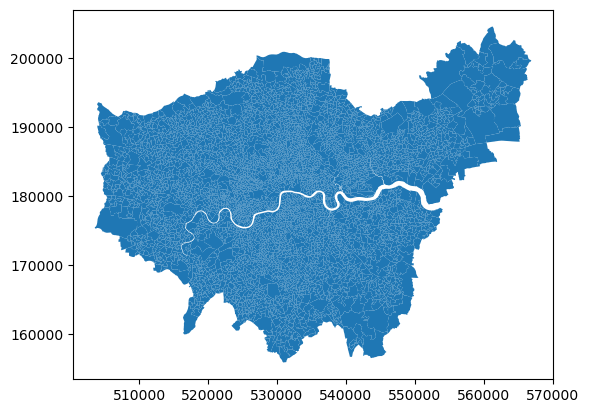

In [36]:
london = boundaries[boundaries['LSOA11NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.plot()

Filtering on 'Brent' in LAD names brings in Brentwood LSOAs. Remove these areas:

In [37]:
london = london[~london['LSOA11NM'].str.contains('Brentwood')]

<AxesSubplot:>

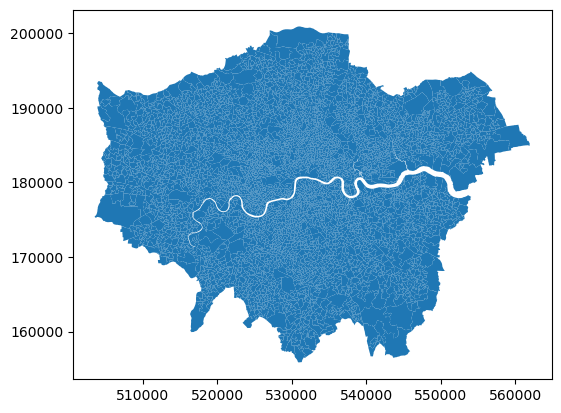

In [38]:
london.plot()

In [39]:
lookup.drop(['OA11CD', 'ObjectId'], axis=1, inplace=True)
lookup.drop_duplicates(subset=['LSOA11NM'], inplace=True)
lookup.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London
8,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London
16,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London
17,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London


### Join MSOA and LAD info

In [40]:
merge_london = pd.merge(london, lookup, how='left', on='LSOA11CD')
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4835 non-null   int64   
 1   LSOA11CD    4835 non-null   object  
 2   LSOA11NM_x  4835 non-null   object  
 3   BNG_E       4835 non-null   int64   
 4   BNG_N       4835 non-null   int64   
 5   LONG_       4835 non-null   float64 
 6   LAT         4835 non-null   float64 
 7   Shape_Leng  4835 non-null   float64 
 8   Shape__Are  4835 non-null   float64 
 9   Shape__Len  4835 non-null   float64 
 10  geometry    4835 non-null   geometry
 11  LSOA11NM_y  4835 non-null   object  
 12  MSOA11CD    4835 non-null   object  
 13  MSOA11NM    4835 non-null   object  
 14  LAD11CD     4835 non-null   object  
 15  LAD11NM     4835 non-null   object  
dtypes: float64(5), geometry(1), int64(3), object(7)
memory usage: 642.1+ KB


In [41]:
merge_london = merge_london[['LSOA11CD', 'LSOA11NM_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'geometry']]
merge_london.rename(columns = {'LSOA11NM_x':'LSOA11NM'}, inplace = True)
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 302.2+ KB


In [42]:
census_opath = Path("../data/geographies/census/")
merge_london.to_file(census_opath / "london-2011-lsoa.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [43]:
#merge_london.to_csv("../data/geographies/census/london2011-lsoa.csv")  #not written as large file size

## Simplify Full Resolution Geometries
Data files from full resolution boundaries written to file are quite large (~40MB for .shp and ~65MB for .csv). Use GeoPandas.simplify to reduce file size.

First check CRS of the file to understand units for tolerance parameter. 

In [44]:
merge_london.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [45]:
merge_london_simple = merge_london.copy(deep=False)
merge_london_simple.geometry = merge_london.simplify(tolerance=10)
merge_london_simple.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532151.537 181867.433, 532308.875 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532634.497 181926.016, 532618.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,"POLYGON ((533619.062 181402.364, 533765.806 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,"POLYGON ((545126.852 184310.838, 545296.239 18..."


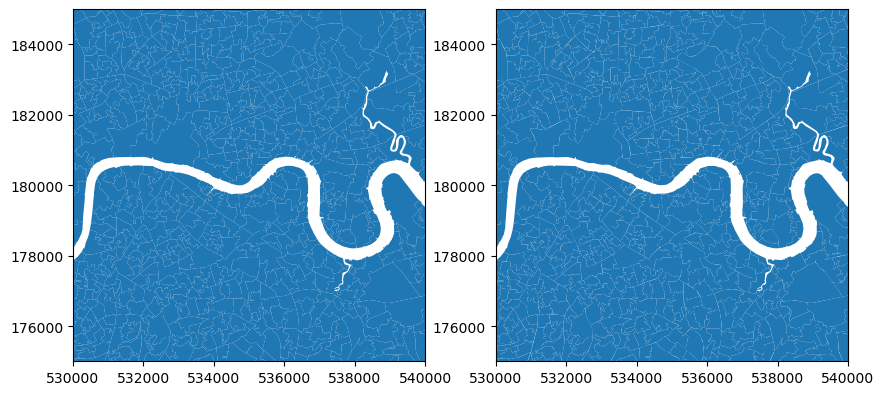

In [46]:
custom_xlim=(530000,540000)
custom_ylim=(175000,185000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

Simplifying with `tolerance=10` seems to have limitied impact on visualisation at intermediate scales.

We can see some impact at fine scales

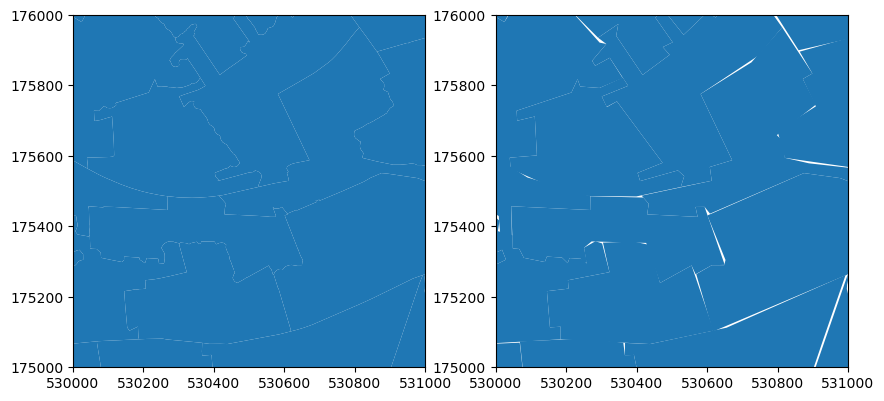

In [47]:
custom_xlim=(530000,531000)
custom_ylim=(175000,176000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

But at Borough level, visualisation is fine. We'll use this tolerance (if students want to use the original we can make that available as .shp).

<AxesSubplot:>

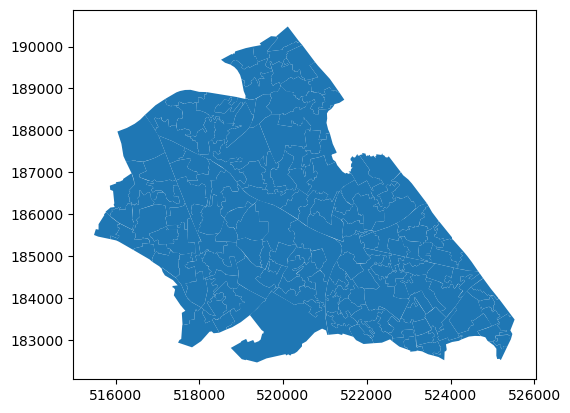

In [48]:
merge_london_simple[merge_london_simple['LSOA11NM'].str.contains('Brent')].plot()

In [49]:
#write to file
merge_london_simple.to_csv(census_opath / "london-2011-lsoa-simple.csv")

Given units for EPSG:27000 (BNG) are metres we also don't need multiple decimal places. We can remove as follows

In [50]:
# first step from https://gis.stackexchange.com/a/336382
merge_london_trunc = merge_london_simple.copy(deep=False)
merge_london_trunc.geometry = merge_london_simple.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,rounding_precision=0)))
merge_london_trunc.geometry = merge_london_trunc.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,trim=True)))

This also seems to have limited impact on visualisation (but will further reduce csv file size):

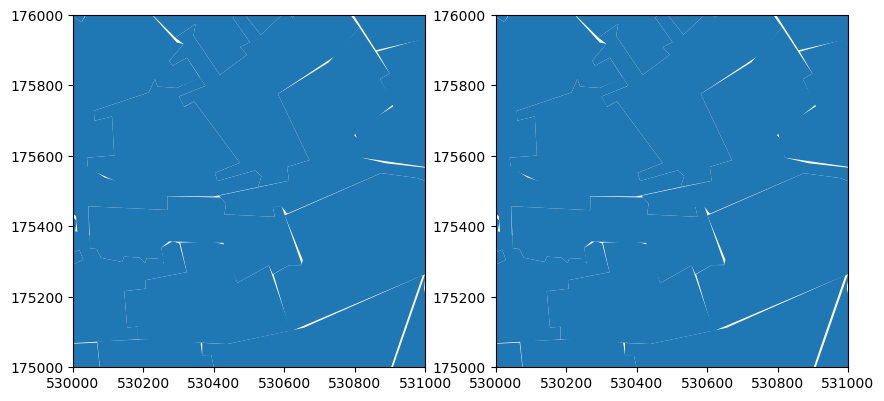

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london_simple.plot(ax=ax[0])
merge_london_trunc.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

<AxesSubplot:>

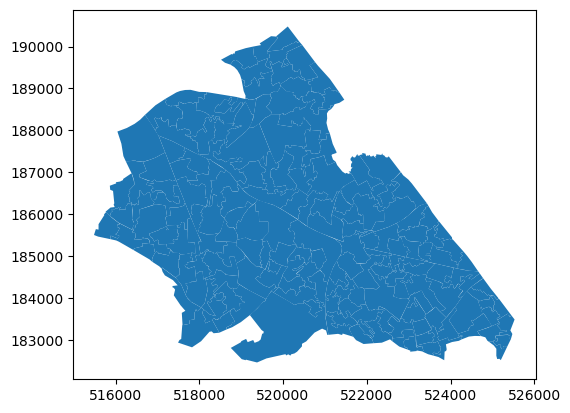

In [52]:
merge_london_trunc[merge_london_trunc['LSOA11NM'].str.contains('Brent')].plot()

So now we can write to file:

In [53]:
merge_london_trunc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 302.2+ KB


In [54]:
merge_london_trunc.to_csv(census_opath / "london-2011-lsoa-trunc.csv", index=False)

## Final checks

Read back in to check:

In [55]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = census_opath / "london-2011-lsoa-trunc.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [56]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


<AxesSubplot:>

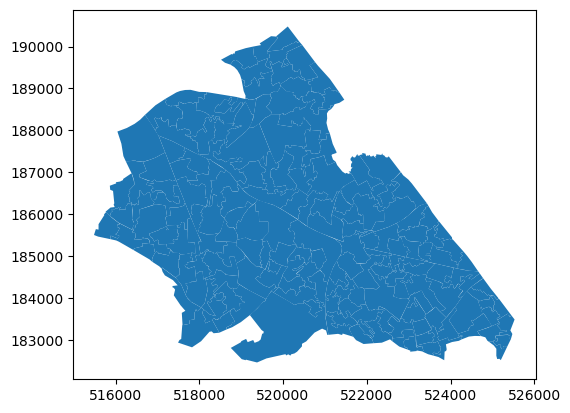

In [57]:
gdf[gdf['LSOA11NM'].str.contains('Brent')].plot()